In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation
import argparse
import yaml
import math
from pyramid import create_pyramid
from continuous_maze import bfs, get_trajectories, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss
import os
import time
from train_streets import get_maze
import wandb

from train_set import PointCloudEncoder, SetDataset

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [107]:
embedding_dim = 2

encoder1 = PointCloudEncoder(input_dim=2, output_dim=embedding_dim).to(device)
encoder2 = PointCloudEncoder(input_dim=2, output_dim=embedding_dim).to(device)

e1_path = f'models/set_experiment1_hyperbolic_False_epochs_512_temp_0.1_trajectories_10000_order__maze_blocker_embeddingdim_{embedding_dim}_gamma_0.1_batch_64_hyp_layers_2_encoder1_epoch_512.pth'
e2_path = f'models/set_experiment1_hyperbolic_False_epochs_512_temp_0.1_trajectories_10000_order__maze_blocker_embeddingdim_{embedding_dim}_gamma_0.1_batch_64_hyp_layers_2_encoder2_epoch_512.pth'

encoder1.load_state_dict(torch.load(e1_path, map_location=torch.device(device)))
encoder2.load_state_dict(torch.load(e2_path, map_location=torch.device(device)))

<All keys matched successfully>

In [108]:
maze = get_maze('blank')
dataset = SetDataset(maze, 1000, num_splits=4)

blank maze
gamma: 0.1


In [112]:
val = dataset[1][0]

val

array([[7.5       , 7.5       ],
       [7.00060513, 7.52459202],
       [6.50633126, 7.60004624],
       [6.00913036, 7.54721384],
       [5.54197706, 7.3689786 ],
       [5.04372484, 7.41074844],
       [4.54730341, 7.47046246],
       [4.5388974 , 6.97053313],
       [4.08217563, 6.76705039],
       [3.65975416, 6.49954319],
       [3.16436677, 6.56730257],
       [2.66943549, 6.63831686],
       [2.52227847, 6.16046248],
       [2.62533405, 5.67119818],
       [2.66185816, 5.17253398],
       [2.61895609, 4.67437797],
       [2.65918274, 4.17599878],
       [2.62455881, 3.67719904],
       [2.13945682, 3.55605424],
       [1.64006344, 3.58067656],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.

torch.Size([20, 2])


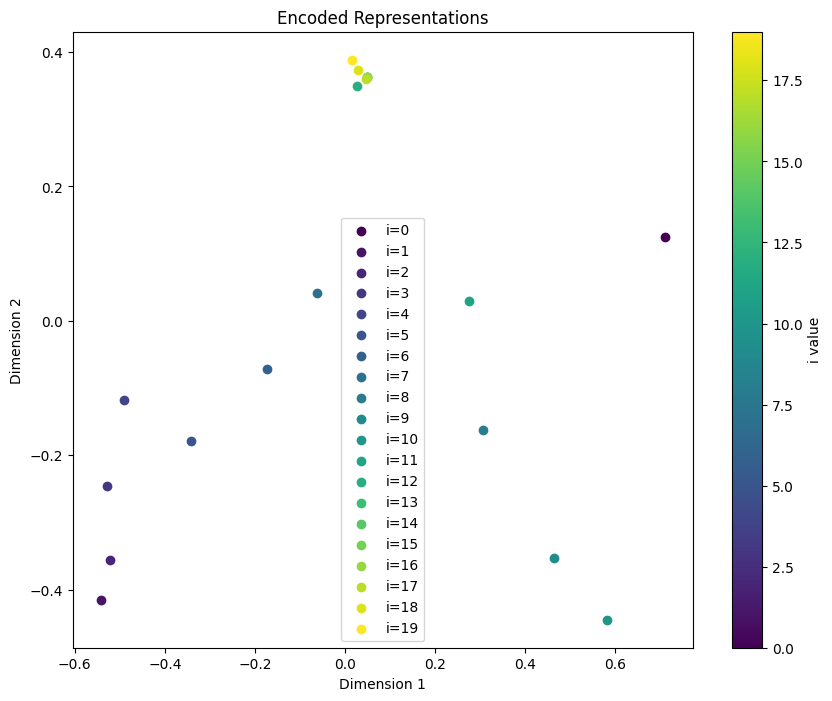

In [113]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

l = []
for i in range(20):
    blank = np.zeros((100, 2))
    blank[:i,:] = val[:i,:]
    l.append(np.array(blank))
s = torch.as_tensor(np.stack(l), dtype=torch.float32, device=device)
s_enc = encoder1(s)
print(s_enc.shape)

with torch.no_grad():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a colormap
    cmap = plt.get_cmap('viridis')  # You can change 'viridis' to any other colormap
    
    # Normalize color values
    norm = mcolors.Normalize(vmin=0, vmax=len(s_enc)-1)
    
    # Plot each point with a color from the colormap
    for i in range(len(s_enc)):
        scatter = ax.scatter(x=s_enc[i,0], y=s_enc[i,1], 
                    color=cmap(norm(i)), 
                    label=f'i={i}')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='i value')
    
    ax.set_title('Encoded Representations')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend()
    plt.show()

torch.Size([25, 2])


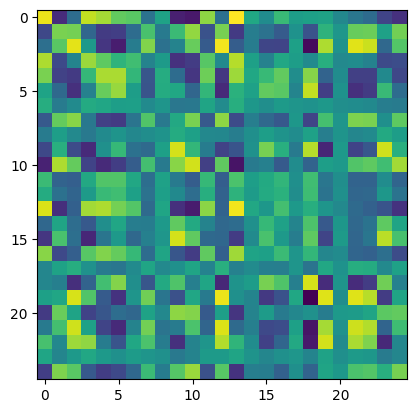

In [118]:
pairs = [dataset[i] for i in range(25)]


s1 = torch.as_tensor(np.stack([x[0] for x in pairs]), dtype=torch.float32, device=device)
s2 = torch.as_tensor(np.stack([x[1] for x in pairs]), dtype=torch.float32, device=device)

s1_enc = encoder1(s1)
s2_enc = encoder2(s2)

print(s1_enc.shape)
with torch.no_grad():
    plt.imshow(s1_enc @ s2_enc.T)

In [117]:
with torch.no_grad():
    plt.scatter(x=s1_enc[:,0], y=s1_enc[:,2], color='b')
    plt.scatter(x=s2_enc[:,0], y=s2_enc[:,2], color='r')

IndexError: index 2 is out of bounds for dimension 1 with size 2

In [13]:
a = torch.randn(size=(32, 100, 2))

encoder1(a)

tensor([[-0.0262,  0.8154],
        [-0.1696, -0.0137],
        [ 0.3480,  0.4876],
        [-0.4686,  0.6231],
        [ 0.1991,  0.4834],
        [ 0.5872,  0.7385],
        [-0.5628,  0.6523],
        [-0.7598,  0.6564],
        [ 0.3324,  0.2025],
        [ 0.2163,  0.4928],
        [-0.0509,  0.2650],
        [ 0.1035,  0.7987],
        [ 0.4027,  0.2370],
        [ 0.0202,  0.3206],
        [-0.2562,  0.3960],
        [ 0.8254,  0.3031],
        [ 0.1960,  0.6969],
        [-0.0206,  0.6168],
        [-0.1103,  0.6017],
        [ 0.4367,  0.2401],
        [ 0.2432, -0.0178],
        [-0.9128,  0.9124],
        [-0.0984,  0.4631],
        [-0.8311,  0.1111],
        [-0.0317,  0.3493],
        [ 0.6118,  0.3960],
        [ 0.6240,  0.4243],
        [-0.3492,  0.4453],
        [ 0.5097,  0.5498],
        [-0.0696,  0.7381],
        [ 0.2113,  0.0781],
        [-0.0168,  0.2130]], grad_fn=<AddmmBackward0>)